In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#探索的データ分析のためのライブラリインポート
import numpy as np
import pandas as pd
#!pip install -U kaleido
import re
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image, display
!pip install Japanize-matplotlib
import japanize_matplotlib
import os


In [3]:
#データの読み込み
train_df=pd.read_csv("../titanic/train.csv")
test_df=pd.read_csv("../titanic/test.csv")


In [4]:
# 不要な警告を抑える
import warnings
warnings.filterwarnings("ignore" ,message=".*invalid value encountered in.*")

In [5]:
#見やすくinfoを比べる
from io import StringIO
from IPython.display import display , HTML
buffer1=StringIO()
buffer2=StringIO()
train_df.info(buf=buffer1)
test_df.info(buf=buffer2)
info1=buffer1.getvalue()
info2=buffer2.getvalue()
html = f"""
<div style="display: flex; gap: 10px;">
    <div>
        <div style="font-weight: bold; margin-bottom: 5px;">Train</div>
        <pre style="border: 1px solid #ccc; padding: 10px;">{info1}</pre>
    </div>
    <div>
        <div style="font-weight: bold; margin-bottom: 5px;">Test</div>
        <pre style="border: 1px solid #ccc; padding: 10px;">{info2}</pre>
    </div>
</div>
"""
display(HTML(html))


In [6]:
#passengerIDはindexと実質同じであることの確認
assert((train_df["PassengerId"]==train_df.index+1).all())
assert((test_df["PassengerId"]==test_df.index+1+len(train_df)).all())



- assertとは確認のための関数

In [8]:
#性質ごとに特徴量を分ける
target="Survived" #目的変数
cont_num_att=["Age" ,"Fare"] #連続値
disc_num_att=["SibSp" , "Parch"] #離散値
cat_att=["Pclass" , "Embarked" , "Sex"]#カテゴリ変数



# 探索的データ分析
##### Survived
* 訓練データの61%は死亡している
* 訓練データに対して、予測精度61%は最低でも必要
##### Age Fare
* ほとんどの乗客は20~40歳
* ほとんどの乗客の運賃は非常に安い
##### SibSp Parch
* ほとんどの乗客は家族と一緒ではない
##### Sex Pclass Embarked
* 64%男性 7割S 55%3等


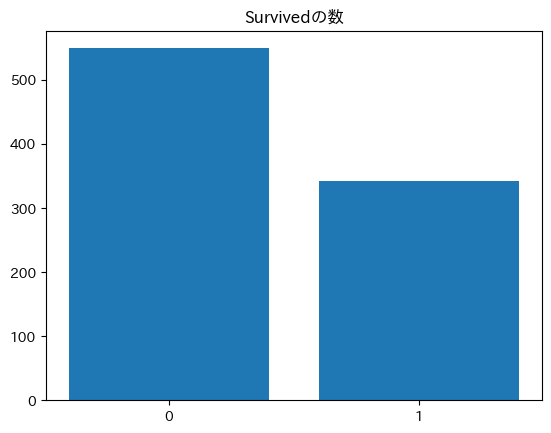

/Users/okadahiroaki/anaconda3/lib/python3.11/site-packages/kaleido/__init__.py:14: UserWarning:




This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.




In [9]:
#survivedの棒グラフを作る

#簡単な棒グラフ
cat,counts=np.unique(train_df["Survived"] ,return_counts=True)#ラベルの種類と個数を算出
plt.bar(x=cat.astype(str) , height=counts)
plt.title("Survivedの数")
plt.show()

#plotlyを使った動的なグラフ
cat,counts=np.unique(train_df[target] ,return_counts=True)
perc=(counts/len(train_df)*100).round(1)#出現率をパーセントで算出
fig = make_subplots(rows=1, cols=1, subplot_titles=[target])
fig.add_trace(
    go.Bar(                            #plotlyの棒グラフ
        x=cat.astype(str),        #文字列にして表記を統一
        y=counts,
        width=0.5,#棒を太すぎないように調整
        text=np.char.add(perc.astype(str), "%"),#○%と表示する
        textfont_size=11,
        hovertext=counts,
        hoverinfo="text",      #ホバーでhovertextのみを表示する
        textposition="outside", #棒グラフの外にtextを表示する
        marker_color="royalblue",
    ),
    row=1,
    col=1,
)
fig.update_yaxes(range=[0,counts.max()*1.15] , row=1 , col=1)#Y軸の上限を適度に上げて、見やすくする
fig.update_layout(title_text="Target")
fig.show()




/Users/okadahiroaki/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/okadahiroaki/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/okadahiroaki/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/okadahiroaki/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/okadahiroaki/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureW

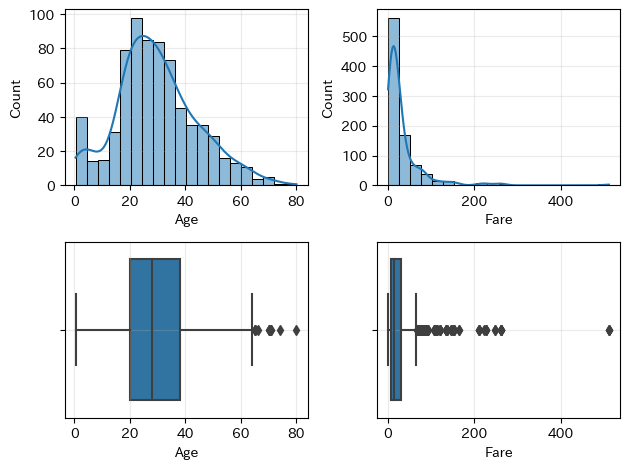

In [10]:
#連続値であるAge Fareの、ヒストグラムと箱ひげ図を作る
n_rows , n_cols = 2 , len(cont_num_att) #縦はヒストグラムと箱ひげ図なので2,横は連続値の特徴量の数なので2
fig,axes=plt.subplots(n_rows,n_cols) 
for i,col in enumerate(cont_num_att):
    sns.histplot(train_df , x=col , kde=True , bins=20 , ax=axes[0,i])#ヒストグラム , カーネル密度関数を表示する,棒の数は20
    axes[0,i].grid(True , alpha=0.25)#薄いグリッドを表示する
    sns.boxplot(data=train_df , x=col  , ax=axes[1,i])#箱ひげ図
    axes[1,i].grid(True , alpha=0.25)
plt.tight_layout() #グラフ同士が重ならないようにする 
plt.show()


- perc=(counts/len(train_df)*100).round(1) ←これは汎用性が高そう
- np.charを使わないと、ndarray型の中にある文字列をあつかえないようなので、覚えておく
- text=「静的なテキスト」hovertext= 「動的なテキスト」だが、hoverinfo="text"はhovertextの方を意味する

/Users/okadahiroaki/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/okadahiroaki/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/okadahiroaki/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/okadahiroaki/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/okadahiroaki/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarni

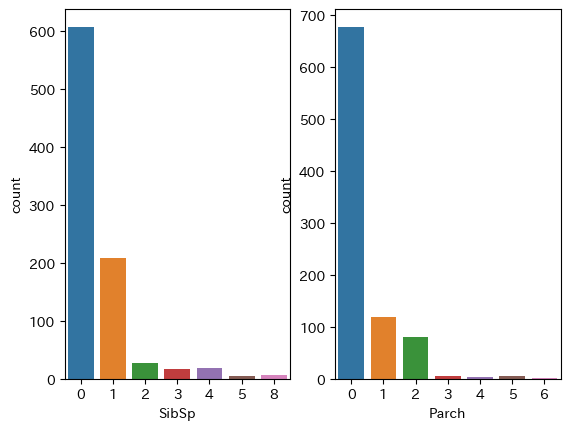

In [11]:
#離散値であるSiSp Parchの棒グラフを作る
   #①seabornで作る
n_rows , n_cols = 1 , len(disc_num_att)#棒グラフを並べる
fig , axes = plt.subplots(n_rows , n_cols)
axes=axes.reshape(n_rows , n_cols)#1次元を2次元に整形
for i , col in enumerate(disc_num_att):#i=0,col=SibSpとi=1,col=Parchが出てくる
    sns.countplot(train_df , x=col , ax=axes[0,i])
plt.show()


   #②plotlyで作る
fig=make_subplots(rows=1, cols = len(disc_num_att),subplot_titles=disc_num_att)

for i,col in enumerate(disc_num_att , start=1):#i=1,col=SibSpとi=2,col=Parchが出てくる
    cat , counts = np.unique(train_df[col] , return_counts=True)
    perc=(counts/len(train_df)*100).round(1)
    fig.add_trace(
        go.Bar(
            x=cat.astype(str),
            y=counts ,
            width=0.5,
             text=np.char.add(perc.astype(str) , "%") ,
            textposition="outside",
             hovertext=counts,
             hoverinfo="text"
            ),
        row=1,
        col=i
    )
    fig.update_yaxes(range=[0,counts.max()*1.15],row=1,col=i)
fig.update_layout(
     width=1000,
    height=500,
     margin=dict(l=35, r=10, t=50, b=5),
)
fig.show()

- plotlyはとても見栄えが良い
- matplotlibはグラフの位置を0,..で指定するが、plotlyは1,...で指定する
- enumerate(start=1)で1,...にできる
- axes.reshape(n_rows,n_cols)では不十分、axes=axes.reshape(n_rows,n_cols)にしなければならない

In [12]:
test_df[cont_num_att].agg(["min","max"]).T

,min,max
Age,0.17,76.0000
Fare,0.00,512.3292


- どうせだったら、テストデータでも同じようにヒストグラムと箱ひげ図を作るのもあり

/Users/okadahiroaki/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/okadahiroaki/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/okadahiroaki/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/okadahiroaki/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/okadahiroaki/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarni

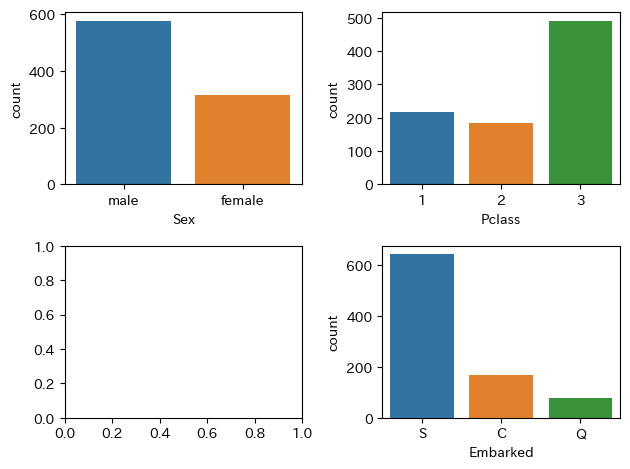

Sex [0.35241302 0.64758698]
Pclass [0.24242424 0.20650954 0.55106622]
Embarked [0.18855219 0.08641975 0.72278339]


In [13]:
#カテゴリ変数の棒グラフを作る

    #①seaborn
fix ,axes=plt.subplots(2,2)
sns.countplot(data=train_df,x="Sex" ,ax=axes[0,0])
sns.countplot(data=train_df ,x="Pclass" ,ax=axes[0,1])
sns.countplot(data=train_df , x="Embarked" ,ax=axes[1,1])
plt.tight_layout()
plt.show()
for col in ["Sex" ,"Pclass" ,"Embarked"]:
    cat,counts=np.unique(train_df[col].dropna() , return_counts=True)
    print(col,counts/len(train_df))


    #②plotly
fig=make_subplots(rows=1, cols = len(cat_att),subplot_titles=cat_att)
for i,col in enumerate(cat_att , start=1):
    cat , counts = np.unique(train_df[col].dropna() , return_counts=True)
    perc=(counts/len(train_df)*100).round(1)
    fig.add_trace(
        go.Bar(
            x=cat.astype(str),
            y=counts ,
            width=0.5,
             text=np.char.add(perc.astype(str) , "%") ,
            textposition="outside",
             hovertext=counts,
             hoverinfo="text"
            ),
        row=1,
        col=i
    )
    fig.update_yaxes(range=[0,counts.max()*1.15],row=1,col=i)
fig.update_layout(
     width=1000,
    height=500,
     margin=dict(l=35, r=10, t=50, b=5),
)
fig.show()


- seabornはplotlyほど見栄えが良くなく、matplotlibほど可変性がないが、とても簡単

In [14]:
print(train_df[cat_att].agg(lambda x: (x.unique())).T)
print(test_df[cat_att].agg(lambda x : (x.unique())).T)

Pclass           [3, 1, 2]
Embarked    [S, C, Q, nan]
Sex         [male, female]
dtype: object
Pclass           [3, 2, 1]
Embarked         [Q, S, C]
Sex         [male, female]
dtype: object


- 訓練データとテストデータで中身に大きな違いがないことを確認するのは大事なのだろう

# Nameから情報を得る
- 全員苗字がわかっている
- 同じ名前の人はいない
- セカンドネームを持っている人がいる
- 同じファーストネームを持つ人のファーストネームの種類は135のみ
- 40%ぐらいの人は同じファーストネームを持つ人がいる。家族かもしれない

In [16]:
assert train_df["Name"].str.match(r"\S.*,").all()#.strでseriesの文字列にアクセス,
                                                #matchで先頭が「r"\S.*,"」で始まることを確認 searchはどこかに含まれていればOK
                                                #raw文字列で\SがSと認識されずにreモジュールに渡せる
                                                #\Sは非空白文字 .は任意の文字列 
                                                #*は直前の.が０回以上繰り返されることを表す ,はそのまま
                                                #先頭が非空白文字で始まり,任意の文字が羅列され、「,」が現れることを確認する
assert test_df["Name"].str.match(r"\S.*,").all()
print(len(train_df),len(np.unique(train_df["Name"])))#同じ名前の人がいないことを確認する
print(len(test_df) , len(np.unique(test_df["Name"])))



891 891
418 418


In [17]:
train_df["Surname"]=train_df["Name"].str.split(",").str[0]#strでそれぞれの文字列にアクセスして、
                                                    #splitで「,」で分割して一旦中身がリストのSeriesを返す
                                                    #strでそれそれのリストにアクセスして[0]で0番目を取得してSeriesを返す
test_df["Surname"]=test_df["Name"].str.split(",").str[0]

print(type(train_df["Name"]))

train_df.head()


<class 'pandas.core.series.Series'>


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen


- strはSeriesの各要素にベクトル化された文字列操作を適用するためのアクセサ
- np.charとSeries.strの共通点 ;「Series型に対して、forなどのループを使わずに一括した文字列処理を行える」
- .strの方が実用的である ; Nanで落ちず、複雑な処理が可能で、正規表現を扱うことができる & np.charの大半を代替可能
- 具体例 ;  text=np.char.add(perc.astype(str) , "%") ⇔text=pd.Series(perc).astype(str)+"%"
- pandas未使用の簡単な処理ならnp.charで良い(軽量だから)

- 苗字という共有されているであろう特徴量を取り出すのは良いグループ分けなのだろう

In [18]:
# Surnames with non-alphabetic characters 
train_df.loc[lambda x: x['Surname'].str.contains(r"[^a-zA-Z '\s]"), ['Surname']]


,Surname
39,Nicola-Yarred
49,Arnold-Franchi
125,Nicola-Yarred
184,Kink-Heilmann
192,Andersen-Jensen
351,Williams-Lambert
353,Arnold-Franchi
430,Bjornstrom-Steffansson
444,Johannesen-Bratthammer
587,Frolicher-Stehli


- DataFrame.loc[lambda x:]においてxは自動的にx=DataFrameになるように設計されている
- loc & ilocはどちらもDataFrameやSeriesからデータの抽出のために使われる
- locの方が、可読性が高いため実用的である(loc[index,columns])
- ilocはリストのように位置で指定するiloc[行:列]

In [21]:
test_df.loc[lambda x : x["Surname"].str.contains(r"[^a-zA-Z '\s]") ,["Surname"]]

,Surname


In [22]:
train_df["Secondary_Surname"]=train_df["Surname"].str.split("-").str[1]
train_df["Surname"]=train_df["Surname"].str.split("-").str[0]

test_df["Secondary_Surname"]=test_df["Surname"].str.split("-").str[1]
test_df["Surname"]=test_df["Surname"].str.split("-").str[0]

In [ ]:
train_df["Surname"].value_counts().loc[lambda x:x>1]
    #.value_countsで要素の種類の数をまとめたSeriesを作る

Surname
Andersson    9
Sage         7
Panula       6
Skoog        6
Johnson      6
            ..
Futrelle     2
Nasser       2
Petroff      2
Cacic        2
Kantor       2
Name: count, Length: 135, dtype: int64


- indexには文字列が入ることもある

In [24]:
train_df["Surname"].value_counts().loc[lambda x : x>1].sum()/len(train_df)


0.4062850729517396

In [25]:
#苗字の頻度を棒グラフにする

fig=go.Figure()
cat,counts=np.unique(train_df["Surname"].value_counts() , return_counts=True)
perc=(counts/len(train_df["Surname"].value_counts())*100).round(1)
fig.add_trace(
    go.Bar(
    x=cat,
    y=counts,
    text=np.char.add(perc.astype(str),"%"),
    hovertext=counts,
    hoverinfo="text",
    textposition="outside",
    width=0.5))
fig.show()


- 棒グラフにすると苗字が性別ほどは大きな影響力を持たないと想像できる

In [27]:
len(set(train_df['Surname'].unique()).intersection(test_df['Surname'].unique()))

145

- 重要な指標であるとは思うけど、本来テストデータは入力も含めて未知であるべきだから実用的な考え方ではないなと思ってしまった

In [29]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Surname',
       'Secondary_Surname'],
      dtype='object')

### Title

In [30]:
assert train_df["Name"].str.contains(r"[A-Za-z]+\.").all()
assert test_df["Name"].str.contains(r"[A-Za-z]+\.").all()

In [31]:
train_df["Name"].head()
train_df["Name"].str.extract(r"([A-Za-z]+)\." , expand=False)

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
       ... 
886     Rev
887    Miss
888    Miss
889      Mr
890      Mr
Name: Name, Length: 891, dtype: object